In [1]:
from __future__ import print_function
import sys

import numpy as np
import cv2

sys.path.append("/workspaces/PheNet-Traffic_light/")

In [2]:
class Object3d(object):
    ''' 3d object label '''

    def __init__(self, label_file_line):
        data = label_file_line.split(' ')
        data[1:] = [float(x) for x in data[1:]]
        self.type = data[0]  #


        # extract 3d bounding box information
        self.t = (data[1], data[2], data[3])  # location (x,y,z) in camera coord.
        self.dis_to_cam = np.linalg.norm(self.t)


    def print_object(self):
        print('Type, truncation, occlusion, alpha: %s, %d, %d, %f' % \
              (self.type, self.truncation, self.occlusion, self.alpha))

In [3]:
def read_label(label_filename):
    lines = [line.rstrip() for line in open(label_filename)]
    objects = [Object3d(line) for line in lines]
    return objects

In [4]:
def get_label(label_file):
    labels = []
    for line in open(label_file, 'r'):
        line = line.rstrip()
        line_parts = line.split(' ')
        gt_id = line_parts[0]
        location = np.array([float(line_parts[1]), float(line_parts[2]), float(line_parts[3])])
        object_label = [gt_id, location]
        labels.append(object_label)
    return labels

In [5]:
class Calibration(object):
    ''' Calibration matrices and utils
        3d XYZ in <label>.txt are in rect camera coord.
        2d box xy are in image2 coord
        Points in <lidar>.bin are in Velodyne coord.
        y_image2 = P^2_rect * x_rect
        y_image2 = P^2_rect * R0_rect * Tr_velo_to_cam * x_velo
        x_ref = Tr_velo_to_cam * x_velo
        x_rect = R0_rect * x_ref
        P^2_rect = [f^2_u,  0,      c^2_u,  -f^2_u b^2_x;
                    0,      f^2_v,  c^2_v,  -f^2_v b^2_y;
                    0,      0,      1,      0]
                 = K * [1|t]
        image2 coord:
         ----> x-axis (u)
        |
        |
        v y-axis (v)
        velodyne coord:
        front x, left y, up z
        rect/ref camera coord:
        right x, down y, front z
        Ref (KITTI paper): http://www.cvlibs.net/publications/Geiger2013IJRR.pdf
        TODO(rqi): do matrix multiplication only once for each projection.
    '''

    def __init__(self, calib_filepath):
        calibs = self.read_calib_file(calib_filepath)
        # Projection matrix from rect camera coord to image2 coord
        self.P2 = calibs['P2']
        self.P2 = np.reshape(self.P2, [3, 4])
        self.P3 = calibs['P3']
        self.P3 = np.reshape(self.P3, [3, 4])
        # Rigid transform from Velodyne coord to reference camera coord
        self.V2C = calibs['Tr_velo2cam']
        self.V2C = np.reshape(self.V2C, [3, 4])
        # Rotation from reference camera coord to rect camera coord
        self.R0 = calibs['R_rect']
        self.R0 = np.reshape(self.R0, [3, 3])

        # Camera intrinsics and extrinsics
        self.c_u = self.P2[0, 2]
        self.c_v = self.P2[1, 2]
        self.f_u = self.P2[0, 0]
        self.f_v = self.P2[1, 1]
        self.b_x = self.P2[0, 3] / (-self.f_u)  # relative
        self.b_y = self.P2[1, 3] / (-self.f_v)

    def read_calib_file(self, filepath):
        with open(filepath) as f:
            lines = f.readlines()

        obj = lines[2].strip().split(' ')[1:]
        P2 = np.array(obj, dtype=np.float32)
        obj = lines[3].strip().split(' ')[1:]
        P3 = np.array(obj, dtype=np.float32)
        obj = lines[4].strip().split(' ')[1:]
        R0 = np.array(obj, dtype=np.float32)
        obj = lines[5].strip().split(' ')[1:]
        Tr_velo_to_cam = np.array(obj, dtype=np.float32)

        return {'P2': P2.reshape(3, 4),
                'P3': P3.reshape(3, 4),
                'R_rect': R0.reshape(3, 3),
                'Tr_velo2cam': Tr_velo_to_cam.reshape(3, 4)}

    def cart2hom(self, pts_3d):
        """
        :param pts: (N, 3 or 2)
        :return pts_hom: (N, 4 or 3)
        """
        pts_hom = np.hstack((pts_3d, np.ones((pts_3d.shape[0], 1), dtype=np.float32)))
        return pts_hom

In [6]:
def project_to_image(pts_3d, P):
    # pts_3d: n x 3
    # P: 3 x 4
    # return: n x 2
    pts_3d_homo = np.concatenate([pts_3d, np.ones((pts_3d.shape[0], 1), dtype=np.float32)], axis=1)
    pts_2d = np.dot(P, pts_3d_homo.transpose(1, 0)).transpose(1, 0)
    pts_2d = pts_2d[:, :2] / pts_2d[:, 2:]

    return pts_2d.astype(np.int)

In [7]:
def get_image(image_file):
    img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
    return img

In [8]:
def get_calib(calib_file):
    return Calibration(calib_file)

In [11]:
calib = get_calib("/workspaces/PheNet-Traffic_light/test_code/data/raw/000172_calib.txt")

In [23]:
img = get_image("/workspaces/PheNet-Traffic_light/test_code/data/raw/000172_image.png")
img.shape
height, width, _ = img.shape

In [13]:
labels = get_label("/workspaces/PheNet-Traffic_light/test_code/data/raw/000172_label.txt")

In [14]:
def compute_box_3d(location):
    # location: 3
    corners_3d = np.array(location, dtype=np.float32).reshape(3, 1)
    return corners_3d.transpose(1, 0)

In [15]:
labels

[['3.0', array([ 7.82601992, -1.17764471, 13.77412062])]]

In [16]:
gt_id, location = labels[0]

In [17]:
location

array([ 7.82601992, -1.17764471, 13.77412062])

In [18]:
x, y, z = location

In [20]:
f = calib.P2[0][0]

In [29]:
ox = calib.P2[0][2]
oy = calib.P2[1][2]
print(ox, oy)

609.5593 172.854


In [36]:
-f * x/z
-f * y/z

61.68924357406197

In [30]:
u = -f * x/z + width
v = -f * y/z + height
print(u, v)

832.0450765803555 436.68924357406195


In [44]:
u1 = f * x/z + width/2
v1 = f * y/z + height/2
print(u1, v1)

1030.9549234196445 125.81075642593802


In [39]:
import matplotlib.pyplot as plt

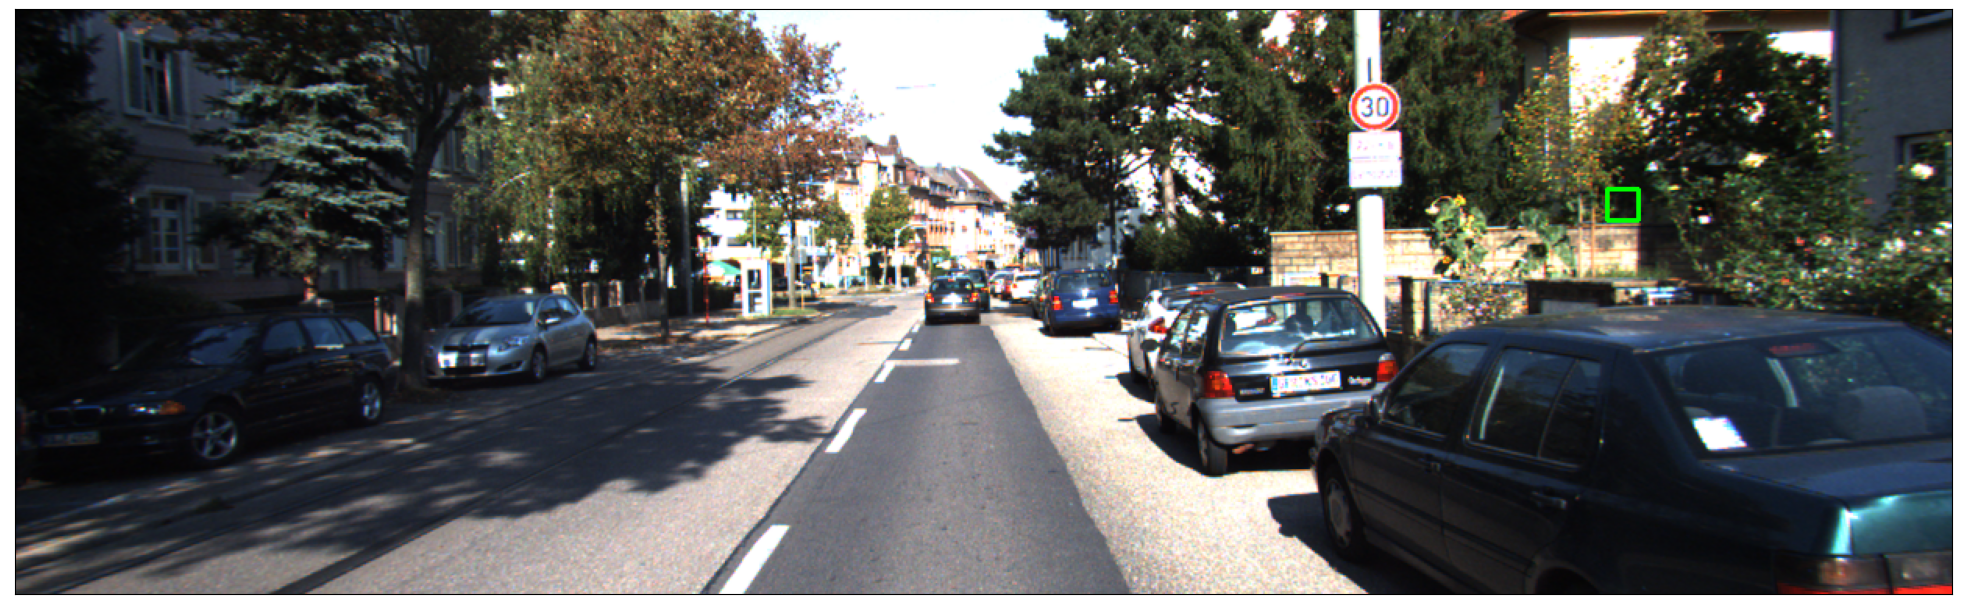

In [45]:
rgb = cv2.cvtColor(cv2.imread('/workspaces/PheNet-Traffic_light/test_code/data/raw/000172_image.png'), cv2.COLOR_BGR2RGB)
x1 = int(u1 - 10)
y1 = int(v1 - 10)
x2 = int(u1 + 10)
y2 = int(v1 + 10)

# Khoanh vùng hình chữ nhật bằng cách vẽ đường bao quanh
cv2.rectangle(rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(25, 13))
plt.imshow(rgb)
plt.yticks([])
plt.xticks([])
plt.show()